In [1]:
#######imports and data read#######
import copy
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from pre_processing import *
from algorithms import *
from spectrum_gen import *
from data_gen import *
from analysis import *
from datasets import *
from evaluation import *
#cr_filtering()
#cr_read_norm()1dasdas
import h5py
import scanpy as sc
from sklearn.metrics import adjusted_rand_score
gene_list_for_plot = ['CDC20','CDK1','RRM2','PCNA']
#adata = sc.read_csv('hela/GSM4224316_out_gene_exon_tagged.dge_exonssf002_KO.txt', delimiter='\t').T
adata = sc.read_csv('hela/GSM4224315_out_gene_exon_tagged.dge_exonssf002_WT.txt', delimiter='\t').T
adata = shuffle_adata(adata)
adata


View of AnnData object with n_obs × n_vars = 1029 × 25797

In [2]:
#######data cleaning#######
#sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(adata, min_genes=0)
i=1
while adata.obs['n_genes'].mean() <4500: #remove cells until we reach mean counts of 4,500 as suggested by https://www.embopress.org/doi/full/10.15252/msb.20209946
    sc.pp.filter_cells(adata, min_genes=i)
    i+=5
#sc.pp.filter_cells(adata, min_counts=3000) #4000
adata_for_inference = adata.copy()
adata

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 683 × 25797
    obs: 'n_genes'

/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


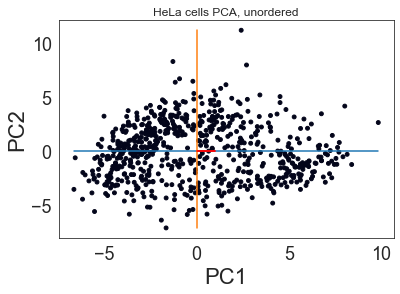

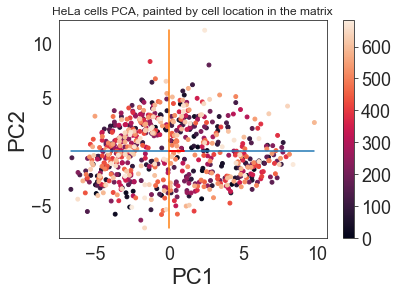

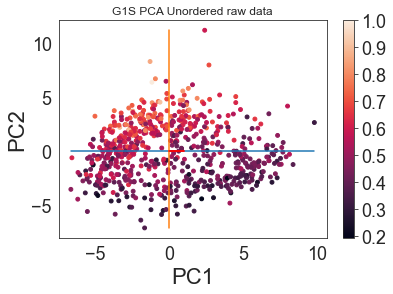

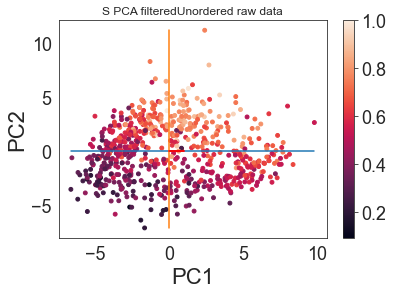

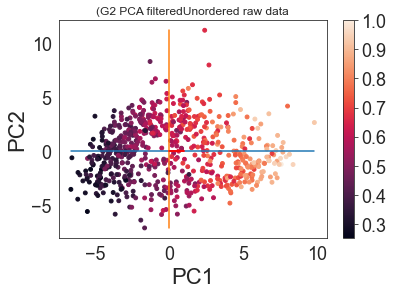

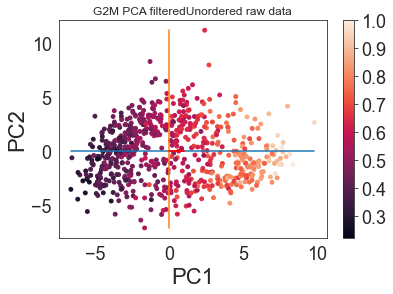

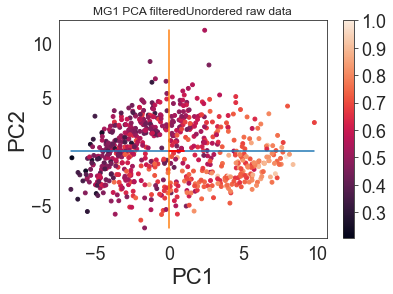

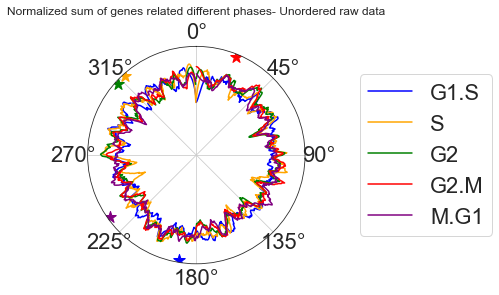

Circular mean and variance, G1S(-2.9753876831739143, 0.9955043911867887)
Circular mean and variance, S(-0.7314111690885372, 0.9946302312014041)
Circular mean and variance, G2(-0.834579179543665, 0.994706280060703)
Circular mean and variance, G2M(0.38771104909508614, 0.9960258049249107)
Circular mean and variance, MG1(-2.192251613131358, 0.9931792860984491)
Mean circular variance= 0.9948091986944512


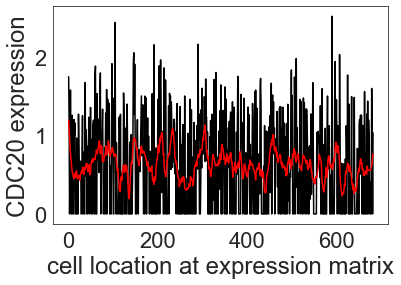

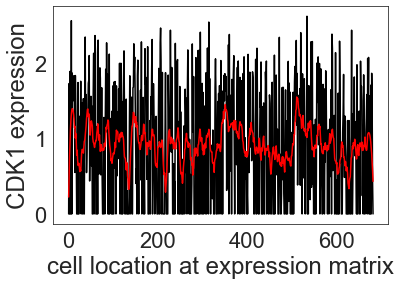

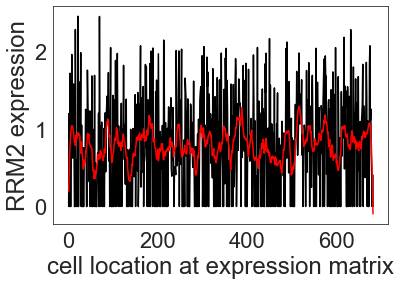

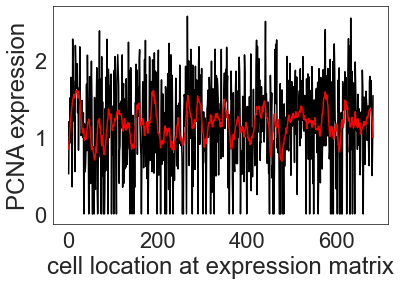

Mean AUC-ROC: 0.2970625


In [3]:
#######data cleaning#######
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
bdata = copy.deepcopy(adata.copy())
sc.pp.filter_genes_dispersion(adata,n_top_genes=7000)
ranged_pca_2d(adata.X,color=np.zeros(adata.X.shape[0]),title=("HeLa cells PCA, unordered"),dis_colorbar=True)
all_plots_hela(adata,title="Unordered raw data")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='r', title="Unordered raw data")
#######Gene inference over un-ordered data- the result expected to be low#######
auc_unordered= np.zeros(100)
for i in range(100):
    auc_unordered[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_unordered)))

Iteration number: 0 function value= 1.192852528966418e-22
Iteration number: 25 function value= 536.5568782462796
Iteration number: 50 function value= 563.4597249046792
Iteration number: 75 function value= 574.3891449362857
Iteration number: 100 function value= 577.8250737077717
Iteration number: 125 function value= 579.2436986082248
Iteration number: 150 function value= 585.6185511388671
Iteration number: 175 function value= 583.7966470941167
Iteration number: 200 function value= 584.3293225153704
Iteration number: 225 function value= 585.4896454325398


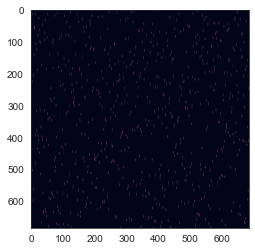

In [4]:
E_sga  , E_rec_sga = reconstruction_cyclic(adata.X , iterNum=250 , batch_size=6000)
plt.imshow(E_sga)
plt.show()

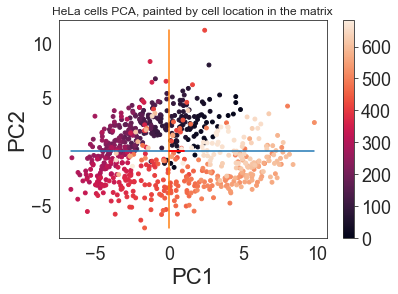

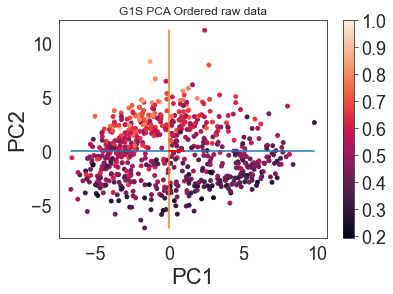

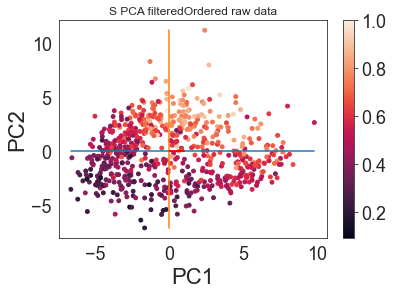

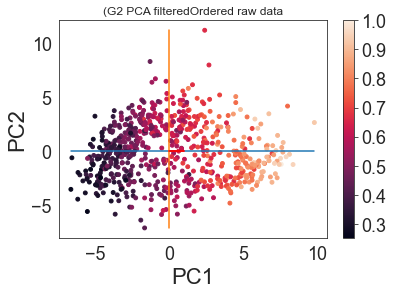

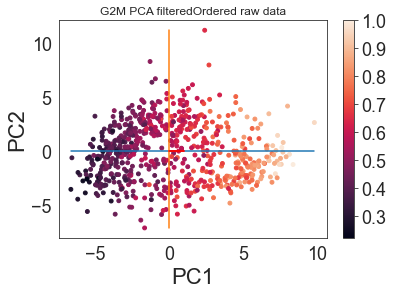

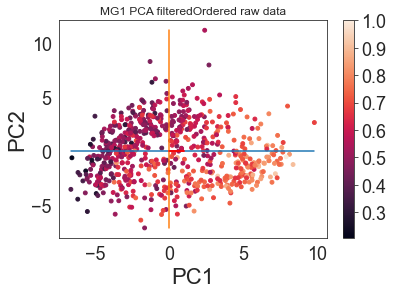

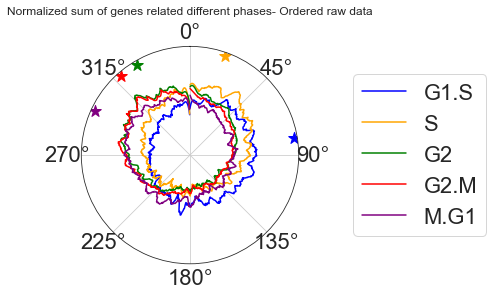

Circular mean and variance, G1S(1.408371352381419, 0.8910757377489235)
Circular mean and variance, S(0.34249063096528903, 0.8310116127310876)
Circular mean and variance, G2(-0.5316060432624466, 0.8126799566322283)
Circular mean and variance, G2M(-0.7199835636100624, 0.8284391062994858)
Circular mean and variance, MG1(-1.1409765314187141, 0.8895235981620994)
Mean circular variance= 0.8505460023147648


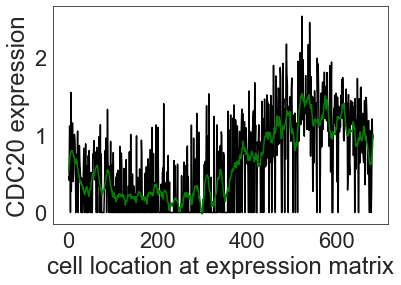

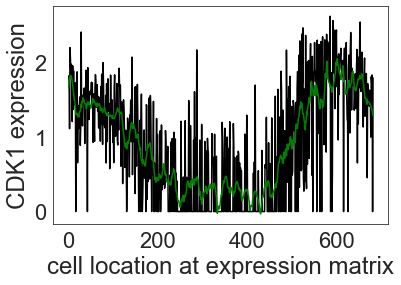

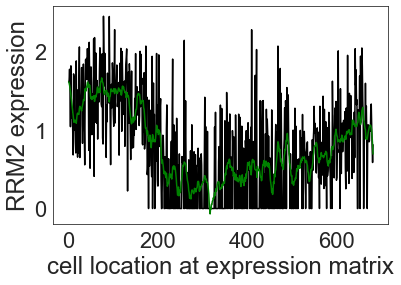

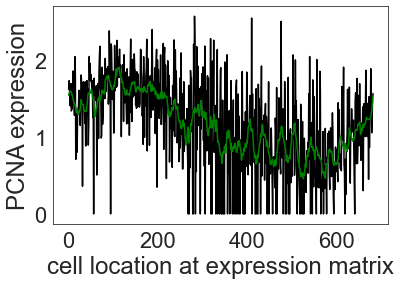

Mean AUC-ROC: 0.8083085000000001


In [5]:
#######Signal reconstruction######
sga_range= e_to_range(E_rec_sga)
adata = adata[sga_range,:]
orig_adata = copy.deepcopy(adata.copy())
all_plots_hela(adata,title="Ordered raw data")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='g', title="Ordered raw data")
auc_ordered= np.zeros(100)
#######Gene inference over ordered data#######
for i in range(100):
    auc_ordered[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_ordered)))

Iteration number: 1 function value: 500.6130919161846
Iteration number: 26 function value: 1093.9393953012736
Iteration number: 51 function value: 2566.037463529415
Iteration number: 76 function value: 3365.8752311304906
norm change 447.808219820656


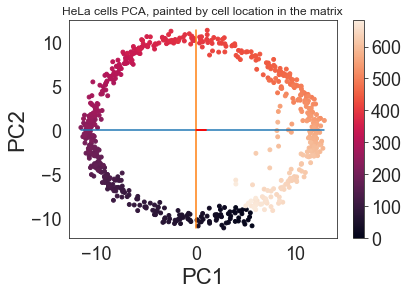

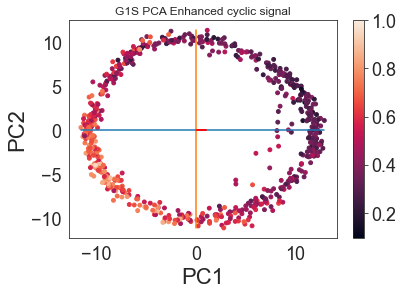

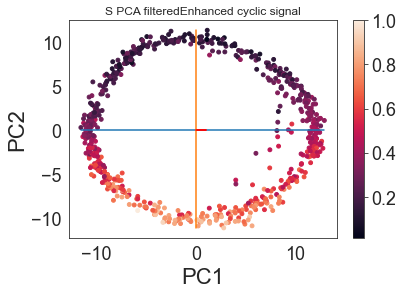

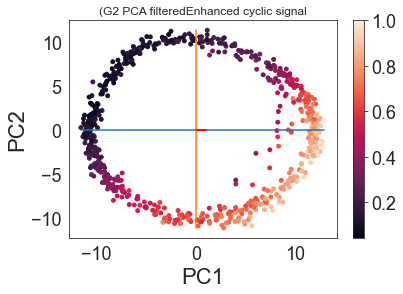

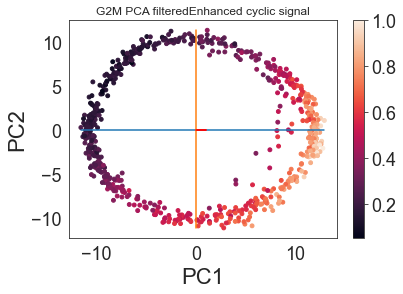

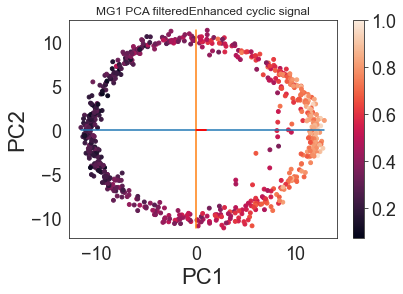

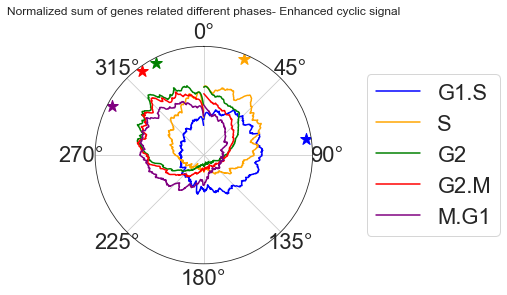

Circular mean and variance, G1S(1.411008037423153, 0.7893530847568392)
Circular mean and variance, S(0.39507729409512493, 0.648537066712495)
Circular mean and variance, G2(-0.4731458439717511, 0.5641869073798037)
Circular mean and variance, G2M(-0.6327039300772597, 0.6376398974058197)
Circular mean and variance, MG1(-1.082990519806517, 0.6947181321852206)
Mean circular variance= 0.6668870176880357


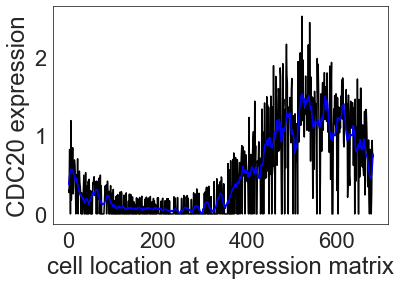

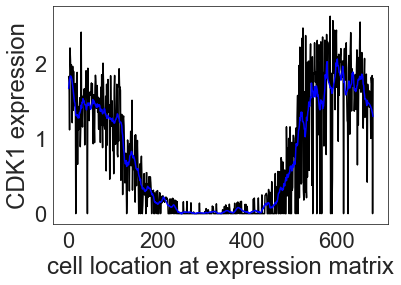

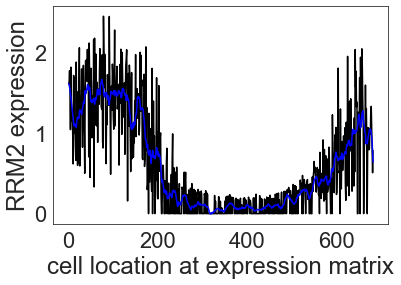

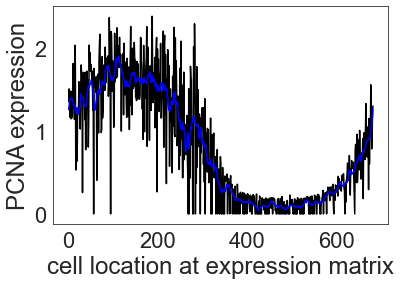

Mean AUC-ROC: 0.8417565


In [6]:
#######Signal enhancement######
adata = orig_adata.copy()
F = enhancement_cyclic(adata.X,regu=0.05,iterNum=100)
print("norm change " +str(np.linalg.norm(orig_adata.X - adata.X * F)))
adata.X = adata.X * F
all_plots_hela(adata,title="Enhanced cyclic signal")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='b', title="Enhanced cyclic signal")
auc_en= np.zeros(100)
for i in range(100):
    auc_en[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_en)))

starting filtering
25th Iteration    Loss :: 104.97882415496726 gradient :: 2.4729929297367557
50th Iteration    Loss :: 50.829839228309474 gradient :: 1.2611460147502296
75th Iteration    Loss :: 33.78608509575655 gradient :: 0.8404262667646456
100th Iteration    Loss :: 25.68341478054016 gradient :: 0.6274415309121866
125th Iteration    Loss :: 20.991549011817497 gradient :: 0.499802089554811
150th Iteration    Loss :: 17.941272525305617 gradient :: 0.4155434191640013
175th Iteration    Loss :: 15.794096875057063 gradient :: 0.3560993086886508
200th Iteration    Loss :: 14.193630064555734 gradient :: 0.31204263219148987
225th Iteration    Loss :: 12.949972828560995 gradient :: 0.27815535457388374
250th Iteration    Loss :: 11.9527913057943 gradient :: 0.25135006876282545
275th Iteration    Loss :: 11.132257035690976 gradient :: 0.22963512884265805
300th Iteration    Loss :: 10.442833505954585 gradient :: 0.2116871917279477
325th Iteration    Loss :: 9.853454512017658 gradient :: 0.19

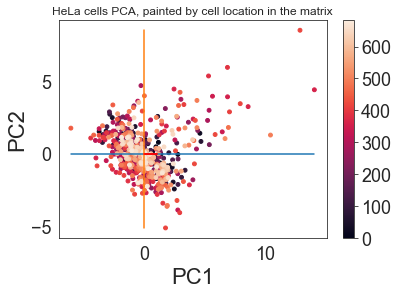

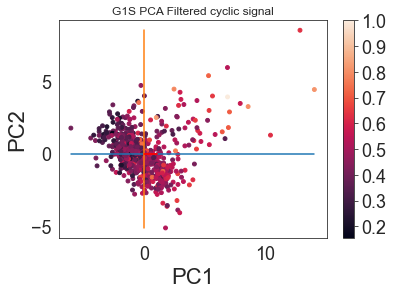

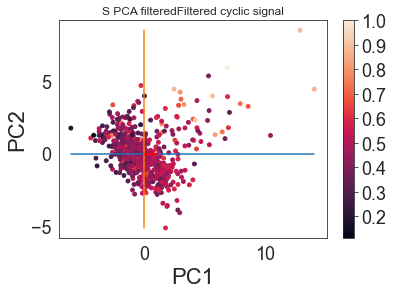

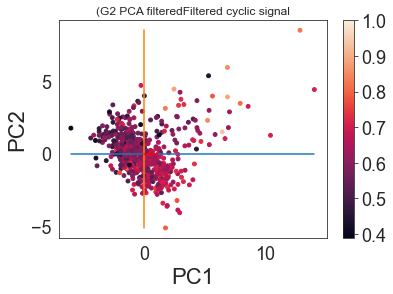

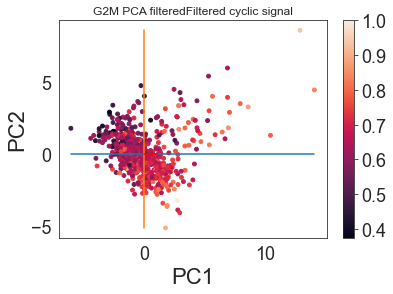

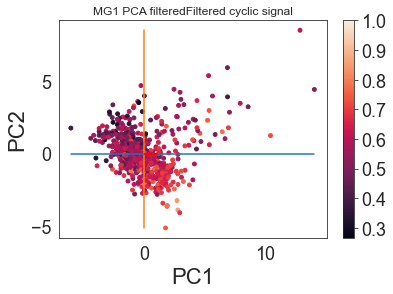

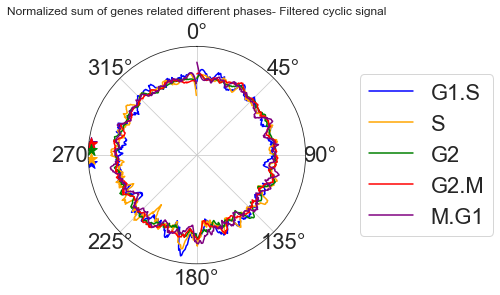

Circular mean and variance, G1S(-1.6449720936713845, 0.9898074030462461)
Circular mean and variance, S(-1.6057844985904741, 0.9891107310454043)
Circular mean and variance, G2(-1.5189612121319076, 0.9888647577390612)
Circular mean and variance, G2M(-1.4668352596658774, 0.9888228570718685)
Circular mean and variance, MG1(-1.4593912910959443, 0.9889700276518588)
Mean circular variance= 0.9891151553108879


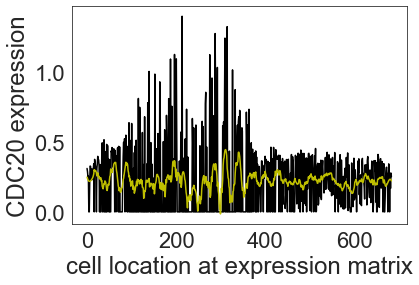

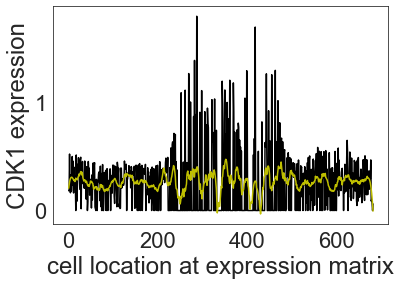

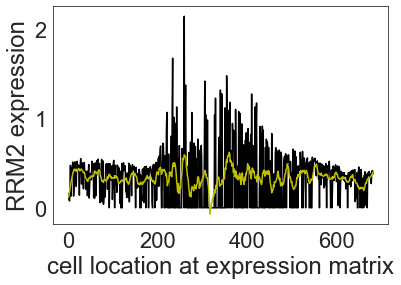

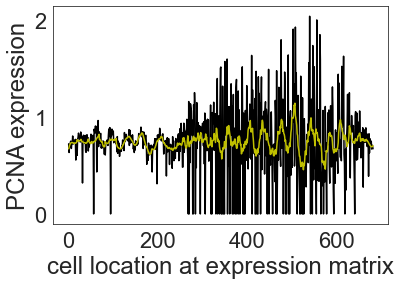

Mean AUC-ROC: 0.18961699999999998


In [7]:
#######Signal filtering######
adata = copy.deepcopy(orig_adata.copy())
F = filtering_cyclic(adata.X,regu=0,iterNum=1500)
print("norm change " +str(np.linalg.norm(orig_adata.X - adata.X * F)))
adata.X = adata.X * F
all_plots_hela(adata,title="Filtered cyclic signal")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='y', title="Filtered cyclic signal")
auc_filtered= np.zeros(100)
for i in range(100):
    auc_filtered[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_filtered)))

starting norm: 885.0439
Iteration number: 1 function value: 500.6241443513101
norm change 48.34790454708213


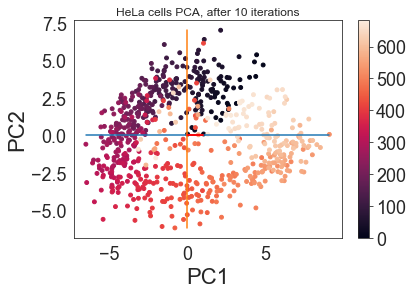

Iteration number: 1 function value: 500.6308403583384
norm change 109.25296481110136


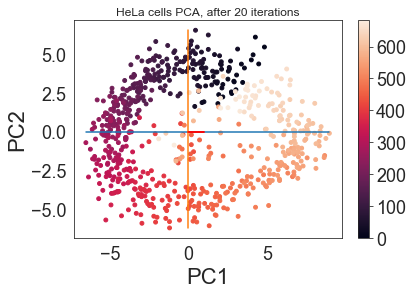

Iteration number: 1 function value: 500.6312577019148
Iteration number: 26 function value: 1094.6979359311515
norm change 192.2070938355038


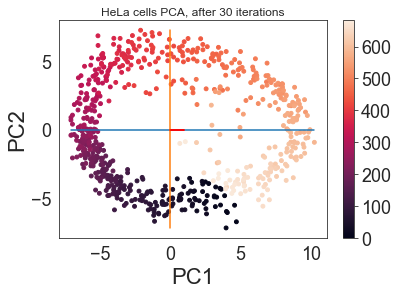

Iteration number: 1 function value: 500.637691706083
Iteration number: 26 function value: 1094.3700327993195
norm change 261.0771748560906


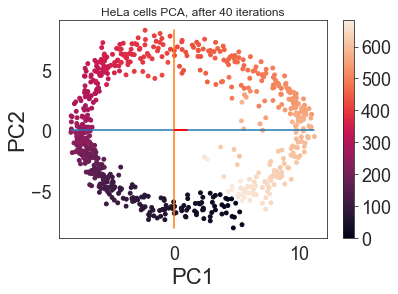

Iteration number: 1 function value: 500.6194496066589
Iteration number: 26 function value: 1093.8609409805454
norm change 311.15150122540604


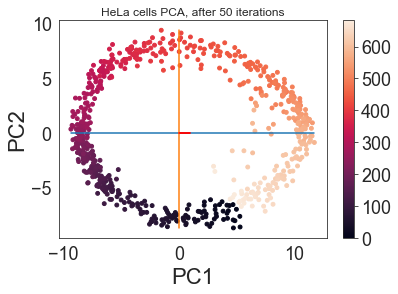

Iteration number: 1 function value: 500.6167961467122
Iteration number: 26 function value: 1093.9871701605161
Iteration number: 51 function value: 2566.1290224969034
norm change 347.4415276380848


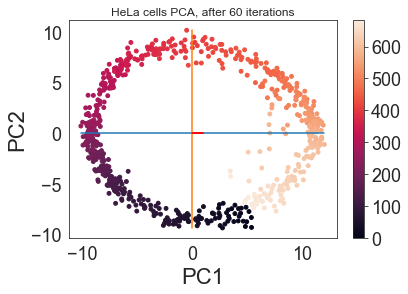

Iteration number: 1 function value: 500.62791987904853
Iteration number: 26 function value: 1094.4227344839617
Iteration number: 51 function value: 2566.553467467205
norm change 377.482248978012


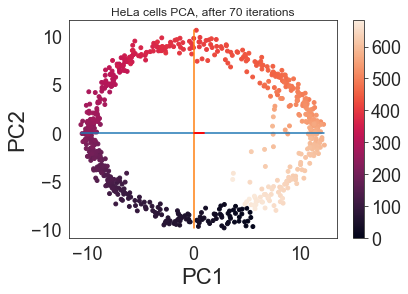

Iteration number: 1 function value: 500.6236267999094
Iteration number: 26 function value: 1094.446488757338
Iteration number: 51 function value: 2566.798970372066
Iteration number: 76 function value: 3366.196215579751
norm change 404.27702993351596


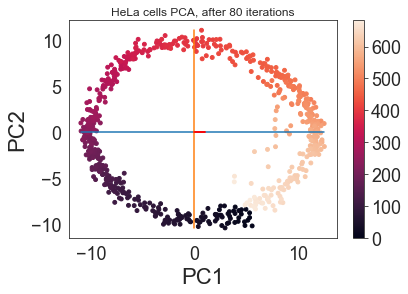

Iteration number: 1 function value: 500.62372666709626
Iteration number: 26 function value: 1094.756595040906
Iteration number: 51 function value: 2566.48046130058
Iteration number: 76 function value: 3366.01168470556
norm change 427.4909290433251


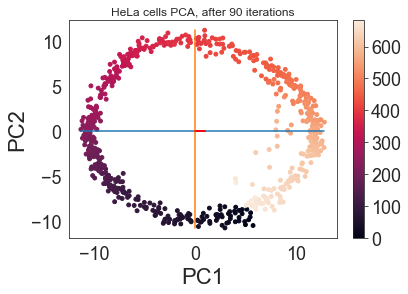

Iteration number: 1 function value: 500.6257128532802
Iteration number: 26 function value: 1094.4622530679417
Iteration number: 51 function value: 2565.900689620031
Iteration number: 76 function value: 3365.1688540728496
norm change 447.78506701900227


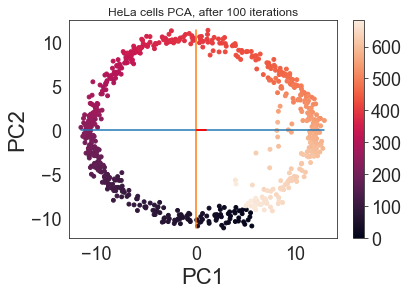

In [8]:
print("starting norm: " +str(np.linalg.norm(orig_adata.X)))
adata = copy.deepcopy(orig_adata.copy())
for i in range(10):
    adata = copy.deepcopy(orig_adata.copy())
    F = enhancement_cyclic(adata.X,regu=0.05,iterNum=(10*(i+1)))
    print("norm change " +str(np.linalg.norm(orig_adata.X - adata.X * F)))
    adata.X = adata.X * F
    ranged_pca_2d(adata.X,color=range(adata.X.shape[0]),title=("HeLa cells PCA, after "+ str((i+1)*10) +" iterations"))

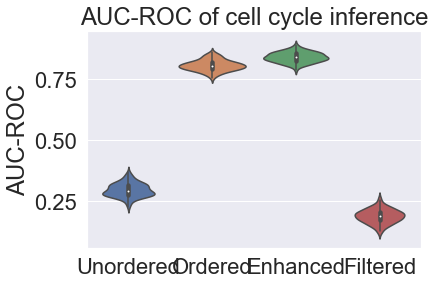

In [9]:
data = pd.DataFrame({
    "Unordered": auc_unordered,
    'Ordered': auc_ordered,
    "Enhanced": auc_en,
    "Filtered": auc_filtered,
})
sns.set_style("whitegrid")

sns.set_style("white", {"axes.facecolor": ".9"})
sns.set_style("whitegrid")

sns.set(font_scale=2)
ax = sns.violinplot(data=data)
plt.ylabel("AUC-ROC")
plt.title("AUC-ROC of cell cycle inference" ,fontsize='24')
plt.show()

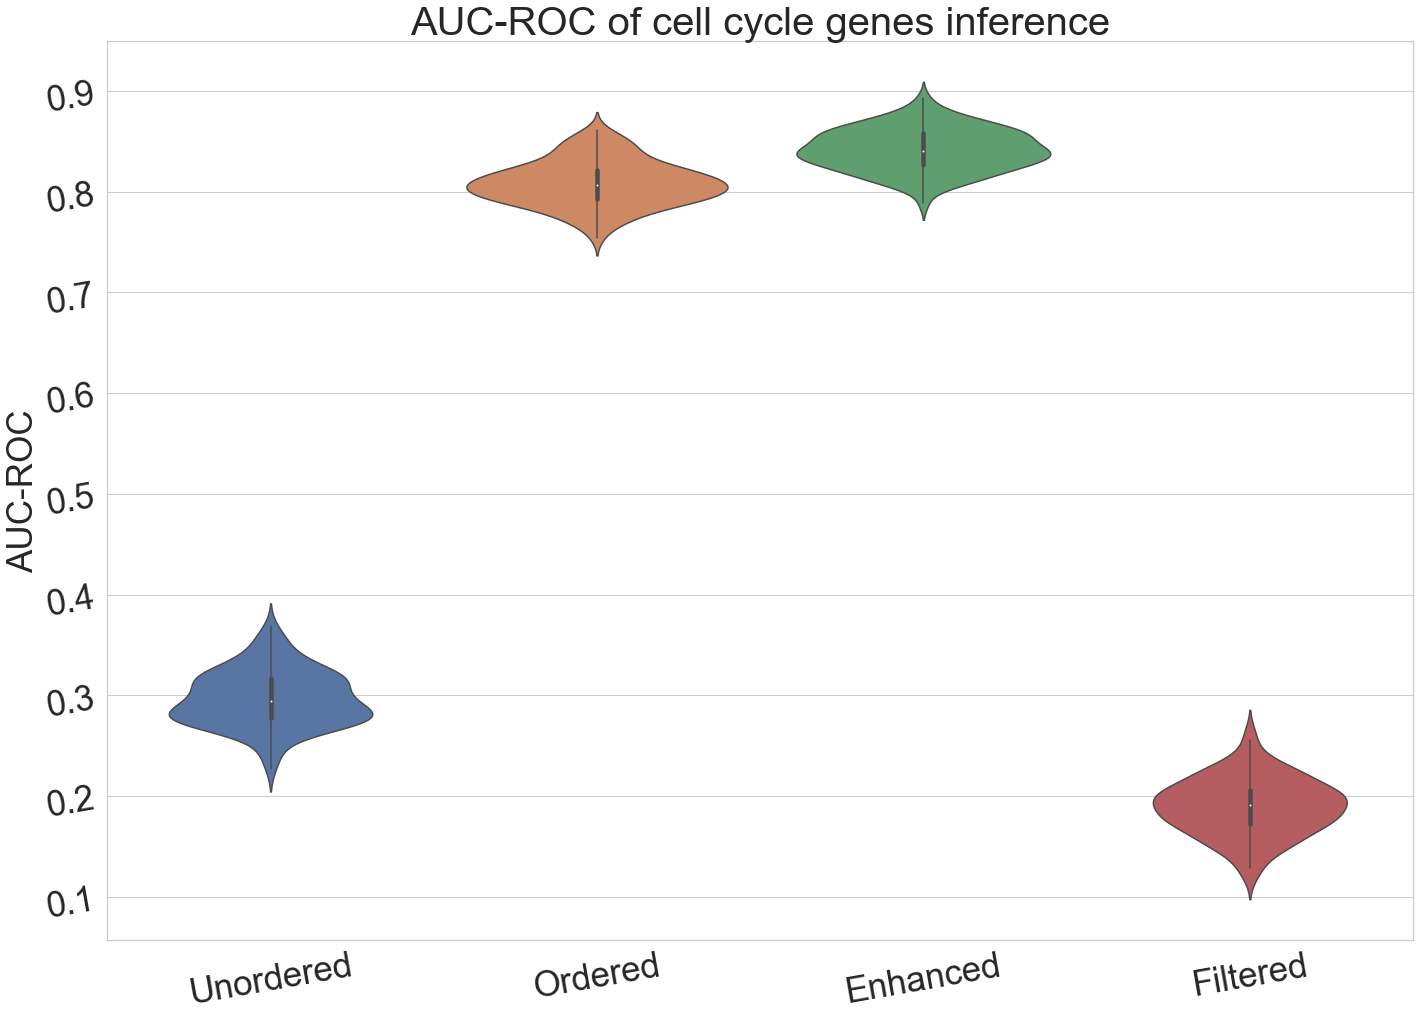

In [11]:
sns.set_style("whitegrid")

b = sns.violinplot(data=data)
#b.axes.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(rc={'figure.figsize':(23.4,16.54)})
b.axes.set_title("AUC-ROC of cell cycle genes inference",fontsize=40)
b.set_ylabel("AUC-ROC",fontsize=35)
b.tick_params(rotation=10,labelsize=35)
#b.axes.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


sns.set(rc={'figure.figsize':(23.4,16.54)})
#plt.title("MSE between simulated cyclic signal and output of enhancement methods" ,fontsize='24')

sns.set_style("whitegrid")

plt.show()